# Cell 0 - Accumulation Signal Sandbox
Explore alternate short-signal formulas using daily_metrics data (read-only). No database writes.

In [5]:
# Cell 1 - Imports and Configuration
from pathlib import Path
import sys

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_root = Path.cwd()
if (project_root / 'darkpool_analysis').exists():
    sys.path.insert(0, str(project_root))

from darkpool_analysis.config import load_config

config = load_config()

TICKER = 'TQQQ'
START_DATE = '2025-11-18'
END_DATE = '2025-12-31'
DB_PATH = config.db_path

# Median-threshold settings
THRESHOLD_K = 0.8

# Figure sizing
FIG_HEIGHT_RATIO = 1.0  # height = width * ratio






In [6]:
# Cell 2 - Styling Constants and Helper Functions
import matplotlib.dates as mdates
import math
from scipy.interpolate import PchipInterpolator

COLORS = {
    'background': '#0f0f10',
    'panel_bg': '#141416',
    'text': '#e6e6e6',
    'text_muted': '#8b8b8b',
    'grid': '#2a2a2d',
    'white': '#ffffff',
    'green': '#00ff88',
    'red': '#ff6b6b',
    'yellow': '#ffd700',
    'cyan': '#00d4ff',
    'orange': '#ff9f43',
    'purple': '#b026ff',
    'neutral': '#6b6b6b',
    'blue': '#4aa3ff',
}
GRID_ALPHA = 0.18
OHLC_LINE_WIDTH = 1.2
SIGNAL_MARKER_SIZE = 60
SIGNAL_EDGE_WIDTH = 0.6


def _rolling_zscore(series, window, min_periods):
    rolling = series.rolling(window=window, min_periods=min_periods)
    mean = rolling.mean()
    std = rolling.std(ddof=0)
    return (series - mean) / std


def _compute_fig_width(day_count):
    if day_count <= 0:
        return 12.0
    buckets = int(np.ceil(day_count / 50))
    return 12.0 * max(1, buckets)


def _apply_axis_style(ax):
    ax.set_facecolor(COLORS['panel_bg'])
    ax.tick_params(colors=COLORS['text'], labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, alpha=GRID_ALPHA, color=COLORS['grid'], linestyle='--')


def _apply_accum_axis_style(ax):
    ax.set_facecolor(COLORS['panel_bg'])
    ax.tick_params(colors=COLORS['text'], labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(COLORS['grid'])
    ax.spines['bottom'].set_color(COLORS['grid'])
    ax.grid(True, axis='y', alpha=GRID_ALPHA, color=COLORS['grid'], linestyle='-')
    ax.grid(False, axis='x')


def _format_volume(value):
    if pd.isna(value):
        return 'NA'
    value = float(value)
    if abs(value) >= 1_000_000_000:
        return f'{value / 1_000_000_000:.1f}B'
    if abs(value) >= 1_000_000:
        return f'{value / 1_000_000:.1f}M'
    if abs(value) >= 1_000:
        return f'{value / 1_000:.0f}K'
    return f'{value:,.0f}'


def _format_plain_int(value):
    if pd.isna(value):
        return 'NA'
    return f'{value:,.0f}'.replace(',', '')


def _set_volume_axis(ax, values):
    series = pd.to_numeric(values, errors='coerce')
    max_val = series.max(skipna=True)
    if pd.isna(max_val) or max_val <= 0:
        max_val = 1.0
    y_max = max_val * 1.1
    ax.set_ylim(0, y_max)
    ax.set_yticks(np.linspace(0, y_max, 5))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: _format_volume(x)))


def _set_flow_axis(ax, values):
    series = pd.to_numeric(values, errors='coerce')
    max_abs = series.abs().max(skipna=True)
    if pd.isna(max_abs) or max_abs == 0:
        max_abs = 1.0
    padding = max_abs * 0.1
    y_max = max_abs + padding
    ax.set_ylim(-y_max, y_max)
    ax.set_yticks(np.linspace(-y_max, y_max, 5))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: _format_volume(x)))



def _plot_smooth_line(ax, x_values, values, color, valid_mask, linewidth=1.0, alpha=0.7, zorder=3):
    """Plot a smooth PCHIP-interpolated line through valid data points."""
    if hasattr(valid_mask, 'sum') and valid_mask.sum() >= 3:
        valid_x = x_values[valid_mask]
        valid_values = values[valid_mask]

        if pd.api.types.is_datetime64_any_dtype(valid_x):
            x_nums = mdates.date2num(pd.to_datetime(valid_x))
            x_smooth = np.linspace(x_nums.min(), x_nums.max(), 150)
            interp = PchipInterpolator(x_nums, np.asarray(valid_values, dtype=float))
            y_smooth = interp(x_smooth)
            x_plot = mdates.num2date(x_smooth)
        else:
            x_nums = np.asarray(valid_x, dtype=float)
            x_smooth = np.linspace(x_nums.min(), x_nums.max(), 150)
            interp = PchipInterpolator(x_nums, np.asarray(valid_values, dtype=float))
            y_smooth = interp(x_smooth)
            x_plot = x_smooth

        ax.plot(
            x_plot,
            y_smooth,
            color=color,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
        )
    else:
        ax.plot(
            x_values[valid_mask],
            values[valid_mask],
            color=color,
            linewidth=linewidth,
            alpha=alpha,
            zorder=zorder,
        )


def _nice_volume_ticks(max_val, target_ticks=6):
    if max_val is None or max_val <= 0 or not np.isfinite(max_val):
        return np.array([0.0, 1.0])
    raw_step = max_val / max(target_ticks - 1, 1)
    magnitude = 10 ** int(math.floor(math.log10(raw_step)))
    while raw_step < magnitude:
        magnitude /= 10
    steps = [1, 2, 5, 10]
    step = steps[0] * magnitude
    for s in steps:
        candidate = s * magnitude
        if candidate <= raw_step:
            step = candidate
    top = math.ceil(max_val / step) * step
    return np.arange(0, top + step, step)
def _plot_ohlc_bars(ax, df_ohlc, x_indices):
    """Plot OHLC bars matching plotter_chart.py style."""
    bar_width = 0.6
    half_width = bar_width / 2

    for xi, (_, row) in zip(x_indices, df_ohlc.iterrows()):
        open_ = row['open']
        high = row['high']
        low = row['low']
        close = row['close']
        if pd.isna(open_) or pd.isna(close) or pd.isna(high) or pd.isna(low):
            continue
        color = COLORS['blue'] if close >= open_ else COLORS['orange']
        ax.vlines(xi, low, high, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(open_, xi - half_width, xi, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)
        ax.hlines(close, xi, xi + half_width, color=color, linewidth=OHLC_LINE_WIDTH, zorder=3)








In [7]:
# Cell 3 - Data Loading and Processing
query = '''
    SELECT
        date,
        symbol,
        short_buy_volume,
        short_sell_volume,
        short_buy_sell_ratio,
        short_buy_sell_ratio_z,
        lit_buy_volume,
        lit_sell_volume,
        lit_flow_imbalance,
        lit_flow_imbalance_z,
        return_z,
        otc_participation_z,
        confidence
    FROM daily_metrics
    WHERE symbol = ? AND date BETWEEN ? AND ?
    ORDER BY date
'''

ohlc_query = '''
    SELECT
        trade_date AS date,
        open,
        high,
        low,
        close,
        volume
    FROM polygon_daily_agg_raw
    WHERE symbol = ? AND trade_date BETWEEN ? AND ?
    ORDER BY trade_date
'''

with duckdb.connect(str(DB_PATH), read_only=True) as conn:
    df = conn.execute(query, [TICKER.upper(), START_DATE, END_DATE]).df()
    df_ohlc = conn.execute(ohlc_query, [TICKER.upper(), START_DATE, END_DATE]).df()

if df.empty:
    raise ValueError(f'No data found for {TICKER} between {START_DATE} and {END_DATE}.')

df['date'] = pd.to_datetime(df['date'])
numeric_cols = [
    'short_buy_volume',
    'short_sell_volume',
    'short_buy_sell_ratio',
    'short_buy_sell_ratio_z',
    'lit_buy_volume',
    'lit_sell_volume',
    'lit_flow_imbalance',
    'lit_flow_imbalance_z',
    'return_z',
    'otc_participation_z',
    'confidence',
]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Process OHLC data
if not df_ohlc.empty:
    df_ohlc['date'] = pd.to_datetime(df_ohlc['date'])
    for col in ['open', 'high', 'low', 'close', 'volume']:
        if col in df_ohlc.columns:
            df_ohlc[col] = pd.to_numeric(df_ohlc[col], errors='coerce')
    # Merge OHLC with metrics on date
    df = df.merge(df_ohlc, on='date', how='left')
else:
    df['open'] = np.nan
    df['high'] = np.nan
    df['low'] = np.nan
    df['close'] = np.nan
    df['volume'] = np.nan

short_buy = df['short_buy_volume'].fillna(0.0)
short_sell = df['short_sell_volume'].fillna(0.0)
lit_buy = df['lit_buy_volume'].fillna(0.0)
lit_sell = df['lit_sell_volume'].fillna(0.0)
total_buy = short_buy + lit_buy
total_sell = short_sell + lit_sell


df['vw_flow'] = np.nan
has_flow = (short_buy > 0) | (short_sell > 0) | (lit_buy > 0) | (lit_sell > 0)
df.loc[has_flow, 'vw_flow'] = total_buy[has_flow] - total_sell[has_flow]
df['vw_flow'] = pd.to_numeric(df['vw_flow'], errors='coerce')
df['vwbr'] = df['vw_flow']

df['finra_buy_volume'] = df['short_buy_volume']

if df['short_buy_sell_ratio'].isna().all():
    valid = df['short_sell_volume'] > 0
    df.loc[valid, 'short_buy_sell_ratio'] = df.loc[valid, 'short_buy_volume'] / df.loc[valid, 'short_sell_volume']

if df['short_buy_sell_ratio_z'].isna().all():
    df['short_buy_sell_ratio_z'] = _rolling_zscore(
        df['short_buy_sell_ratio'], config.short_z_window, config.zscore_min_periods
    )


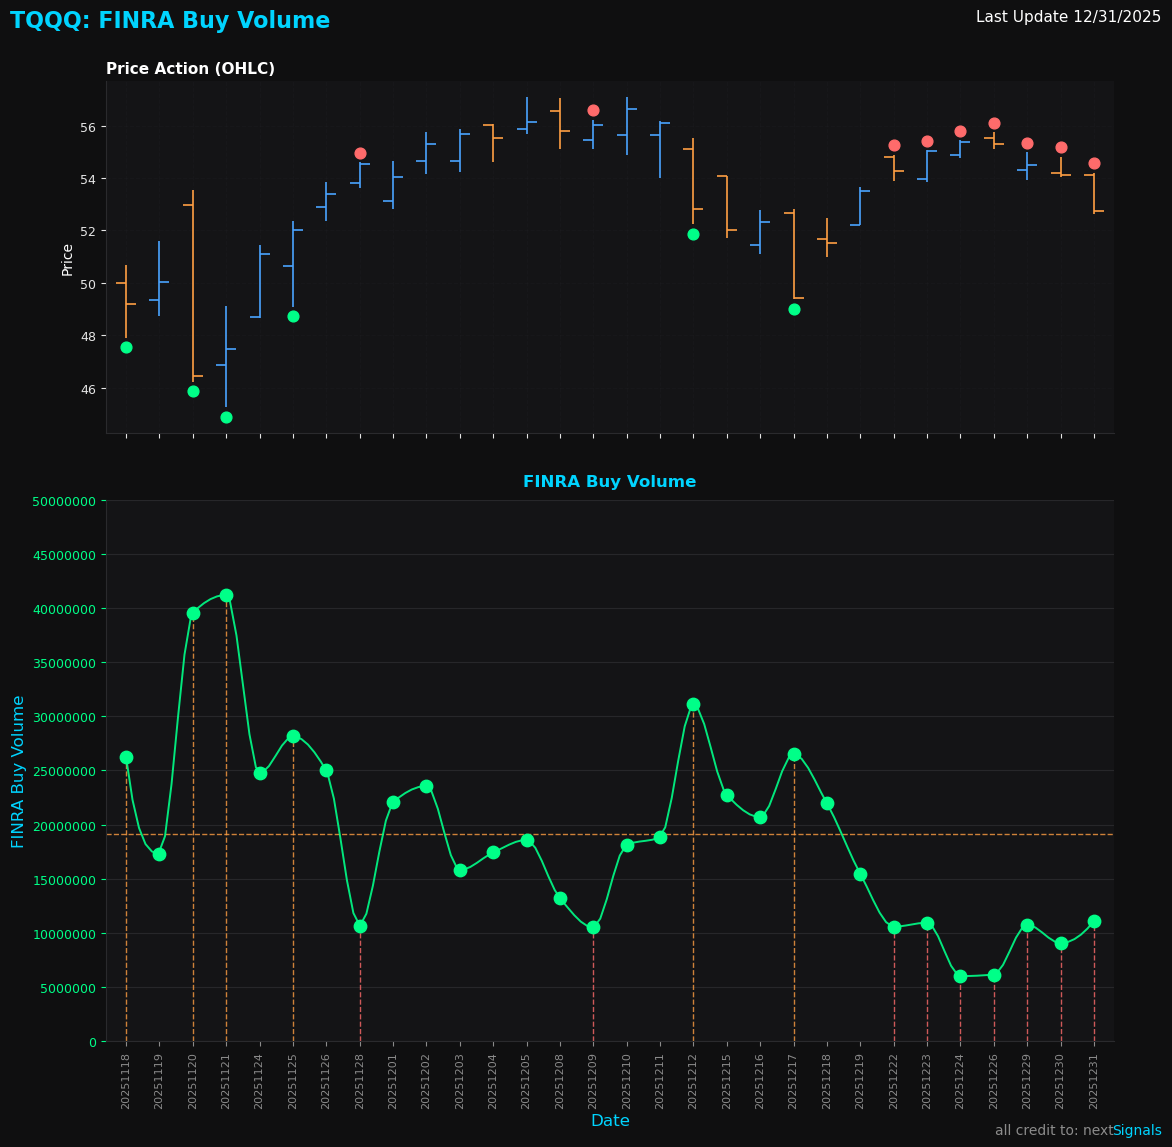

In [8]:
# Cell 4 - Two-Panel Plot (OHLC + Volume-Weighted Accumulation)
plt.style.use('dark_background')

plot_df = df.sort_values('date').copy()
if 'THRESHOLD_K_NEG' not in globals():
    THRESHOLD_K_NEG = THRESHOLD_K

market_mask = plot_df['close'].notna()
plot_df = plot_df.loc[market_mask].copy()
plot_df = plot_df.reset_index(drop=True)
if plot_df.empty:
    raise ValueError('No market days with OHLC data in the selected range.')
x_vals = np.arange(len(plot_df))
x_labels = plot_df['date'].dt.strftime('%Y%m%d').tolist()
if plot_df.empty:
    raise ValueError('No data available to plot after filtering.')

if 'finra_buy_volume' not in plot_df.columns:
    raise ValueError('finra_buy_volume missing from dataset.')
accum_series = plot_df['finra_buy_volume']
if accum_series.isna().all():
    raise ValueError('finra_buy_volume is empty for the selected range.')
plot_df['vw_accum'] = pd.to_numeric(accum_series, errors='coerce')
if not plot_df['vw_accum'].equals(plot_df['finra_buy_volume']):
    raise ValueError('Panel 2 is not plotting finra_buy_volume.')

fig_width = _compute_fig_width(len(plot_df))
fig_height = fig_width * FIG_HEIGHT_RATIO
fig = plt.figure(figsize=(fig_width, fig_height))
fig.patch.set_facecolor(COLORS['background'])

# Layout tuned to keep panel 2 proportions close to the reference image
height_ratios = [1.3, 2]
fig_gs = fig.add_gridspec(
    2, 1,
    height_ratios=height_ratios,
    hspace=0.15,
    left=0.1,
    right=0.94,
    top=0.9,
    bottom=0.1,
)

ax_price = fig.add_subplot(fig_gs[0])
ax_accum = fig.add_subplot(fig_gs[1], sharex=ax_price)

# Panel 1: OHLC bar chart (plotter_chart.py styling)
_apply_axis_style(ax_price)
x_vals = np.arange(len(plot_df))
_plot_ohlc_bars(ax_price, plot_df, x_vals)
ax_price.set_ylabel('Price', color=COLORS['white'], fontsize=10)
ax_price.set_title('Price Action (OHLC)', color=COLORS['white'], fontsize=11, fontweight='bold', loc='left')
ax_price.tick_params(axis='x', labelbottom=False)
if len(x_vals) > 0:
    pad = 0.6
    ax_price.set_xlim(x_vals.min() - pad, x_vals.max() + pad)

# Panel 2: Volume-Weighted Accumulation (match attached style)
_apply_accum_axis_style(ax_accum)
accum = plot_df['vw_accum']
valid_mask = ~accum.isna()

if valid_mask.any():
    _plot_smooth_line(
        ax_accum,
        x_vals,
        accum,
        COLORS['green'],
        valid_mask,
        linewidth=1.4,
        alpha=0.9,
        zorder=3,
    )
    ax_accum.scatter(
        x_vals[valid_mask],
        accum.loc[valid_mask],
        color=COLORS['green'],
        s=80,
        zorder=4,
    )

if valid_mask.any():
    max_val = accum[valid_mask].max()
    min_val = accum[valid_mask].min()
else:
    max_val = 1.0
    min_val = 0.0

if pd.isna(max_val) or max_val <= 0:
    max_val = 1.0

y_min = 0.0
padded_max = max_val * 1.1
y_ticks = _nice_volume_ticks(padded_max)
y_max = float(y_ticks[-1])
ax_accum.set_ylim(y_min, y_max)

ax_accum.set_yticks(y_ticks)
ax_accum.grid(True, axis='y', linestyle='-', color=COLORS['grid'], alpha=0.9, linewidth=0.8)
ax_accum.set_axisbelow(True)
ax_accum.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: _format_plain_int(x)))
ax_accum.tick_params(axis='y', colors=COLORS['green'])
ax_accum.set_ylabel('FINRA Buy Volume', color=COLORS['cyan'], fontsize=12)
ax_accum.set_title('FINRA Buy Volume', color=COLORS['cyan'], fontsize=12, fontweight='bold', loc='center', pad=10)

if valid_mask.any():
    mean_val = accum[valid_mask].mean()
    ax_accum.axhline(
        mean_val,
        color=COLORS['orange'],
        linestyle='--',
        linewidth=1.0,
        alpha=0.8,
        zorder=2,
    )

    std_val = accum[valid_mask].std(ddof=0)
    pos_threshold = mean_val + (THRESHOLD_K * std_val if std_val and std_val > 0 else 0.0)
    pos_idx = accum[valid_mask][accum[valid_mask] >= pos_threshold].index
    if len(pos_idx) == 0:
        top_n = min(5, len(accum[valid_mask]))
        pos_idx = accum[valid_mask].nlargest(top_n).index

    neg_threshold = mean_val - (THRESHOLD_K_NEG * std_val if std_val and std_val > 0 else 0.0)
    neg_idx = accum[valid_mask][accum[valid_mask] <= neg_threshold].index
    if len(neg_idx) == 0:
        bottom_n = min(5, len(accum[valid_mask]))
        neg_idx = accum[valid_mask].nsmallest(bottom_n).index

    price_lows = plot_df['low'].to_numpy()
    price_highs = plot_df['high'].to_numpy()
    price_min = np.nanmin(price_lows) if np.isfinite(price_lows).any() else np.nan
    price_max = np.nanmax(price_highs) if np.isfinite(price_highs).any() else np.nan
    if not np.isfinite(price_min) or not np.isfinite(price_max):
        price_min = np.nanmin(plot_df['close'].to_numpy()) if np.isfinite(plot_df['close'].to_numpy()).any() else np.nan
        price_max = np.nanmax(plot_df['close'].to_numpy()) if np.isfinite(plot_df['close'].to_numpy()).any() else np.nan
    if np.isfinite(price_min) and np.isfinite(price_max):
        offset = (price_max - price_min) * 0.03
        if not np.isfinite(offset) or offset == 0:
            offset = 1.0
        if len(pos_idx) > 0:
            pos_x = x_vals[pos_idx]
            pos_lows = plot_df.loc[pos_idx, 'low'].to_numpy()
            pos_marker_y = pos_lows - offset
            ax_price.scatter(
                pos_x,
                pos_marker_y,
                s=60,
                color=COLORS['green'],
                zorder=5,
            )
        if len(neg_idx) > 0:
            neg_x = x_vals[neg_idx]
            neg_highs = plot_df.loc[neg_idx, 'high'].to_numpy()
            neg_marker_y = neg_highs + offset
            ax_price.scatter(
                neg_x,
                neg_marker_y,
                s=60,
                color=COLORS['red'],
                zorder=5,
            )

    for idx in pos_idx:
        x_val = x_vals[idx]
        y_val = accum.loc[idx]
        ax_accum.vlines(
            x_val,
            y_min,
            y_val,
            color=COLORS['orange'],
            linestyle='--',
            linewidth=1.0,
            alpha=0.8,
            zorder=2,
        )

    for idx in neg_idx:
        x_val = x_vals[idx]
        y_val = accum.loc[idx]
        ax_accum.vlines(
            x_val,
            y_min,
            y_val,
            color=COLORS['red'],
            linestyle='--',
            linewidth=1.0,
            alpha=0.8,
            zorder=2,
        )

ax_accum.set_xticks(x_vals)
ax_accum.set_xticklabels(x_labels, rotation=90, ha='center', fontsize=8, color=COLORS['text_muted'])
ax_accum.tick_params(axis='x', labelbottom=True, colors=COLORS['text_muted'])
ax_accum.set_xlabel('Date', color=COLORS['cyan'], fontsize=12)

last_update = plot_df['date'].max()
if pd.notna(last_update):
    last_update = pd.to_datetime(last_update)
    last_update_str = f"{last_update.month}/{last_update.day}/{last_update.year}"
else:
    last_update_str = 'NA'

fig.text(
    0.02,
    0.96,
    f"{TICKER}: FINRA Buy Volume",
    color=COLORS['cyan'],
    fontsize=16,
    fontweight='bold',
    ha='left',
    va='top',
)
fig.text(
    0.98,
    0.96,
    f"Last Update {last_update_str}",
    color=COLORS['white'],
    fontsize=11,
    ha='right',
    va='top',
)

fig.text(0.94, 0.02, 'all credit to: next', color=COLORS['text_muted'], fontsize=10, ha='right', va='bottom')
fig.text(0.98, 0.02, 'Signals', color=COLORS['cyan'], fontsize=10, ha='right', va='bottom')



# Optional save
output_path = config.plot_dir / f"{TICKER.lower()}_wtd_vwbr_{START_DATE}_{END_DATE}.png"
fig.savefig(output_path, dpi=150, facecolor=COLORS['background'], edgecolor='none')

plt.show()




















